**What I want to do: ** After making a few submissions, I want to devise a method to ascertain the accuracy and sensitivity of my predictions based on the validation set. Naturally, I would want to run this first before actually submitting to kaggle, but hey, this isn't real life.

## Admin stuff

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from datetime import datetime
import re

In [3]:
data_dir = "data_redux"
train_path = "data_redux/train/"
test_path = "data_redux/test/"
validation_path = "data_redux/valid/"
sample_train_path = "data_redux/sample/train/"
sample_validation_path = "data_redux/sample/valid/"
results_path = "data_redux/results/"

In [4]:
# some useful utilities and the vgg16 model
import utils; reload(utils)
from utils import plots
from utils import save_array, load_array

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [5]:
# import the vgg16 model
import vgg16; reload(vgg16)
from vgg16 import Vgg16, image

In [6]:
# instantiate the vgg16 model
vgg = Vgg16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


## Load model weights into the vgg16 model

In [7]:
vgg.model.load_weights(results_path+'fulltraining.h5')

## Visualise results using the validation set

Jeremy's big idea is to run 5 different kinds of visual tests to gain intuition about model performance:<br>
1. get a bunch of labels correctly labeled at random
2. get a bunch of lables incorrectly labeled at random
3. get a bunch of labels that are most correctly labeled (highest probability and turned out to be right)
4. get a bunch of most incorrectly labeled (highest probability and turned out to be incorrect)
5. get a bunch of labels most unsure of (mid range probability)

In [8]:
!ls $sample_validation_path

cat  dog


In [9]:
batch_size = 64

In [10]:
valBatches, preds = vgg.test(validation_path, batch_size=batch_size)

Found 5000 images belonging to 2 classes.


In [11]:
preds[:10]

array([[  1.0000e+00,   2.2803e-20],
       [  1.0000e+00,   2.5139e-15],
       [  1.0000e+00,   1.9808e-13],
       [  1.0000e+00,   1.7677e-17],
       [  9.2700e-01,   7.3000e-02],
       [  1.0000e+00,   4.4912e-13],
       [  1.0000e+00,   1.8486e-15],
       [  9.9955e-01,   4.4857e-04],
       [  1.0000e+00,   4.0578e-10],
       [  1.0000e+00,   9.9499e-18]], dtype=float32)

In [12]:
valBatches.filenames[:10]

['cat/cat.1000.jpg',
 'cat/cat.10000.jpg',
 'cat/cat.10002.jpg',
 'cat/cat.10007.jpg',
 'cat/cat.1001.jpg',
 'cat/cat.1002.jpg',
 'cat/cat.10023.jpg',
 'cat/cat.10025.jpg',
 'cat/cat.10026.jpg',
 'cat/cat.10030.jpg']

### Compare actuals with predicted performance

In [13]:
valBatches.classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [93]:
actual_dog = [1 if 'dog' in file else 0 for file in valBatches.filenames]
actual_dog = np.array(actual_dog)
actual_dog[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
predicted_dog = np.dot(preds,[0,1])
predicted_dog[:10]

array([  2.2803e-20,   2.5139e-15,   1.9808e-13,   1.7677e-17,   7.3000e-02,   4.4912e-13,
         1.8486e-15,   4.4857e-04,   4.0578e-10,   9.9499e-18])

In [16]:
import pandas as pd

In [17]:
df_perf = pd.DataFrame({
        'filename':valBatches.filenames,
        'actuals':actual_dog,
        'predicted':predicted_dog
    })
df_perf.head(10)

,actuals,filename,predicted
0,0,cat/cat.1000.jpg,2.280302e-20
1,0,cat/cat.10000.jpg,2.513856e-15
2,0,cat/cat.10002.jpg,1.980797e-13
3,0,cat/cat.10007.jpg,1.767664e-17
4,0,cat/cat.1001.jpg,7.299965e-02
5,0,cat/cat.1002.jpg,4.491209e-13
6,0,cat/cat.10023.jpg,1.848602e-15
7,0,cat/cat.10025.jpg,4.485663e-04
8,0,cat/cat.10026.jpg,4.057832e-10
9,0,cat/cat.10030.jpg,9.949876e-18


## Prepare plots

In [57]:
# number of plots to view at the same time
nView=4

In [19]:
def plot_idx(idx, titles=None, sample=False):
    if sample==True:
        plots([image.load_img(sample_validation_path+valBatches.filenames[i]) for i in idx],titles=titles)
    else:
        plots([image.load_img(validation_path+valBatches.filenames[i]) for i in idx],titles=titles)

### Plot where pred = actual

In [58]:
correct = np.where(actual_dog==np.round(predicted_dog,0))[0]
correct

array([   0,    1,    2, ..., 4997, 4998, 4999])

In [59]:
idx = np.random.choice(correct,nView, replace=False)
idx

array([3300, 2207, 2093, 3929])

In [60]:
titles = [predicted_dog[i] for i in idx]
titles

[1.0, 4.9865947953048833e-17, 0.0015166874509304762, 1.0]

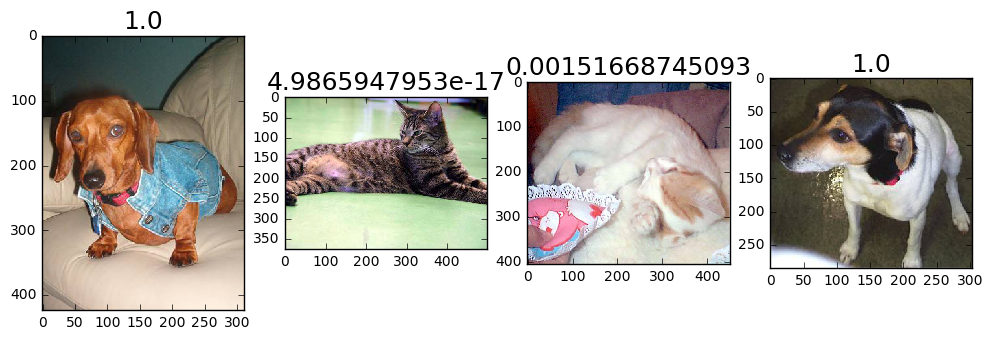

In [61]:
plot_idx(idx,titles=titles, sample=False)

### Plot a bunch of random incorrect

In [62]:
incorrect = np.where(actual_dog!=np.round(predicted_dog,0))[0]
incorrect[:10]

array([ 40, 110, 207, 225, 394, 542, 566, 590, 636, 708])

In [63]:
idx = np.random.choice(incorrect,nView, replace=False)
idx

array([ 590, 1930, 3883, 3965])

In [64]:
titles = [predicted_dog[i] for i in idx]
titles

[0.96423232555389404,
 0.74167114496231079,
 0.37142670154571533,
 0.13829460740089417]

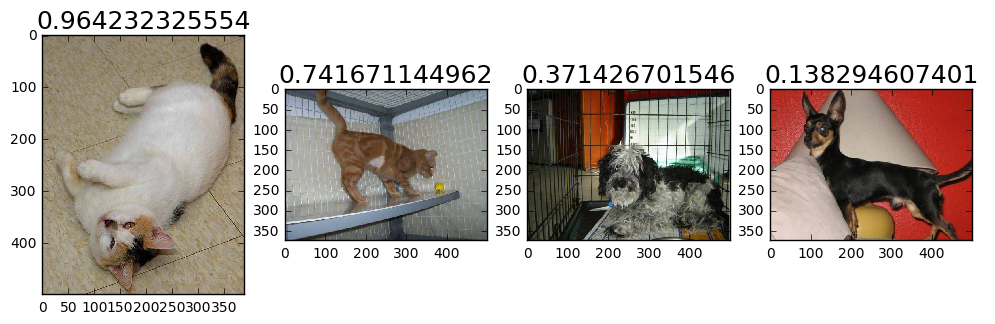

In [65]:
plot_idx(idx,titles=titles, sample=False)

The image size is either too small (120/150 pix) or the image is not in focus (the dog/cat is not the main object of focus)..

Reasonable but still not human-like.

### Plot most confident and got it wrong!

In [130]:
incorrect_cats = np.where((actual_dog==1) & (actual_dog!=np.round(predicted_dog,0)))[0]
most_confident_as_cat_but_wrong = np.argsort(predicted_dog[incorrect_cats])[::-1][:nView]
idx = incorrect_cats[most_confident_as_cat_but_wrong]
idx

array([4479, 4168, 3883, 3489])

In [131]:
titles = [valBatches.filenames[i] for i in idx]
titles

['dog/dog.7588.jpg',
 'dog/dog.6243.jpg',
 'dog/dog.4925.jpg',
 'dog/dog.3147.jpg']

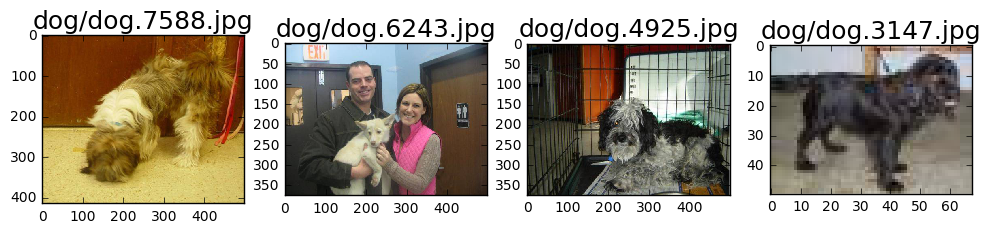

In [132]:
plot_idx(idx,titles=titles, sample=False)

Whoa. There's a lot going on in each of the pictures.

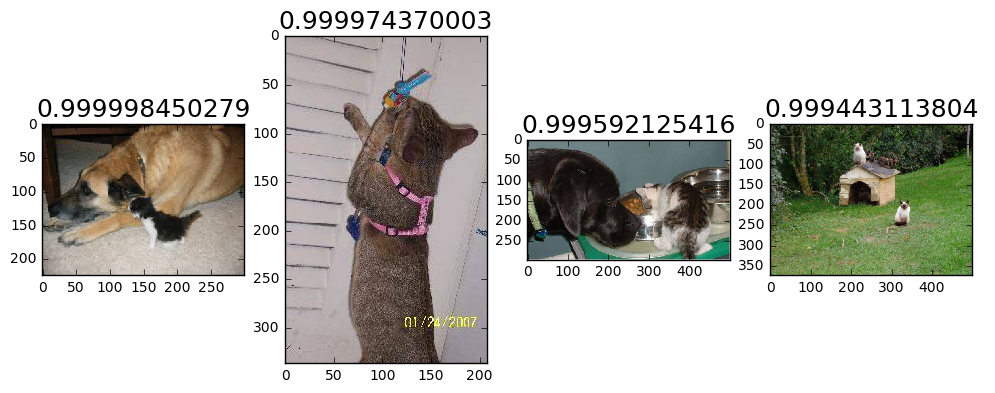

In [135]:
# similarly for dog
incorrect_dogs = np.where((actual_dog==0) & (actual_dog!=np.round(predicted_dog,0)))[0]
most_confident_as_dog_but_wrong = np.argsort(predicted_dog[incorrect_dogs])[::-1][:nView]
idx = incorrect_dogs[most_confident_as_dog_but_wrong]
titles = [predicted_dog[i] for i in idx]
plot_idx(idx,titles=titles, sample=False)

Well, some of them are genuinely hard even for a human.

### Plot ones that the model was most uncertain about

In [136]:
predicted_dog-0.5

array([-0.5   , -0.5   , -0.5   , ...,  0.5   ,  0.4999,  0.4998])